# ARZ Solver — API Test Notebook

Interactive tests for the `numerical_solvers.arz` public API:
- Initial condition builders: `riemann`, `three_region`, `from_steps`
- Solvers: `generate_one`, `generate_n`
- Physics helpers: `pressure`, `dp_drho`, `eigenvalues`

In [1]:
import torch
import matplotlib.pyplot as plt

from numerical_solvers.arz import (
    generate_one,
    generate_n,
    pressure,
    dp_drho,
    eigenvalues,
    riemann,
    three_region,
    from_steps,
)

%matplotlib inline

# Shared grid parameters
NX = 200
DX = 0.005
DT = 0.0005
NT = 2000
GAMMA = 1.0

x = torch.linspace(0.5 * DX, NX * DX - 0.5 * DX, NX)

## 1. Single Riemann Problem

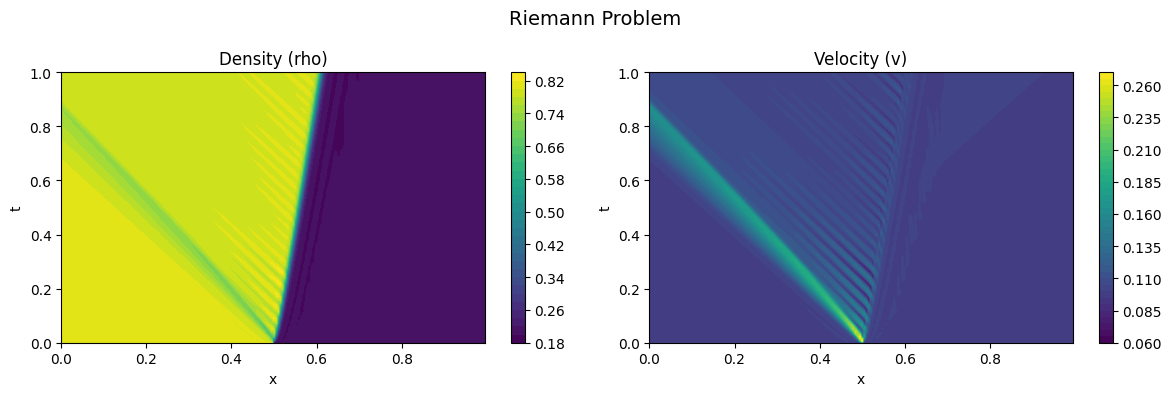

rho shape: torch.Size([2001, 200])
v   shape: torch.Size([2001, 200])
w   shape: torch.Size([2001, 200])


In [2]:
rho0, v0 = riemann(x, rho_left=0.8, rho_right=0.2, v0=0.1)
sol = generate_one(rho0, v0, dx=DX, dt=DT, nt=NT, gamma=GAMMA)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, key, title in zip(axes, ["rho", "v"], ["Density (rho)", "Velocity (v)"]):
    c = ax.contourf(
        sol["x"].numpy(),
        sol["t"].numpy(),
        sol[key].numpy(),
        levels=40,
        cmap="viridis",
    )
    fig.colorbar(c, ax=ax)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(title)
fig.suptitle("Riemann Problem", fontsize=14)
fig.tight_layout()
plt.show()

print(f"rho shape: {sol['rho'].shape}")
print(f"v   shape: {sol['v'].shape}")
print(f"w   shape: {sol['w'].shape}")

## 2. Three-Region IC

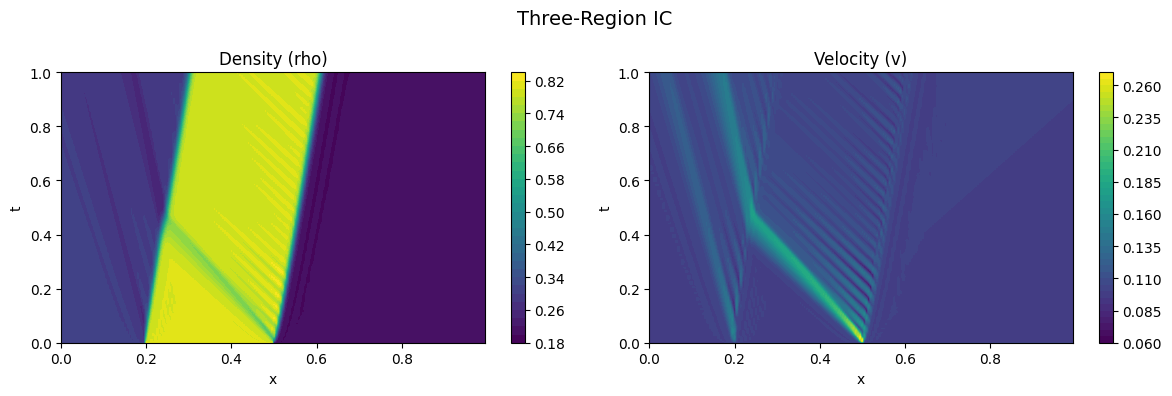

In [3]:
rho0_3, v0_3 = three_region(x, rho_left=0.3, rho_mid=0.8, rho_right=0.2, v0=0.1)
sol3 = generate_one(rho0_3, v0_3, dx=DX, dt=DT, nt=NT, gamma=GAMMA)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, key, title in zip(axes, ["rho", "v"], ["Density (rho)", "Velocity (v)"]):
    c = ax.contourf(
        sol3["x"].numpy(),
        sol3["t"].numpy(),
        sol3[key].numpy(),
        levels=40,
        cmap="viridis",
    )
    fig.colorbar(c, ax=ax)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(title)
fig.suptitle("Three-Region IC", fontsize=14)
fig.tight_layout()
plt.show()

## 3. Custom Piecewise IC (`from_steps`)

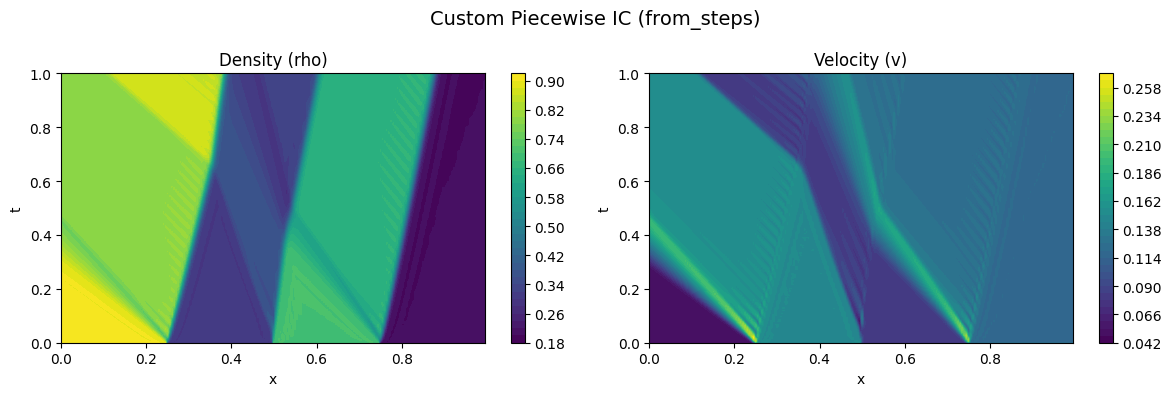

In [4]:
rho_steps = [(0.25, 0.9), (0.5, 0.3), (0.75, 0.7), (1.0, 0.2)]
v_steps = [(0.25, 0.05), (0.5, 0.15), (0.75, 0.08), (1.0, 0.12)]

rho0_s, v0_s = from_steps(x, rho_steps=rho_steps, v_steps=v_steps)
sol_s = generate_one(rho0_s, v0_s, dx=DX, dt=DT, nt=NT, gamma=GAMMA)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, key, title in zip(axes, ["rho", "v"], ["Density (rho)", "Velocity (v)"]):
    c = ax.contourf(
        sol_s["x"].numpy(),
        sol_s["t"].numpy(),
        sol_s[key].numpy(),
        levels=40,
        cmap="viridis",
    )
    fig.colorbar(c, ax=ax)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(title)
fig.suptitle("Custom Piecewise IC (from_steps)", fontsize=14)
fig.tight_layout()
plt.show()

## 4. Boundary Condition Variants

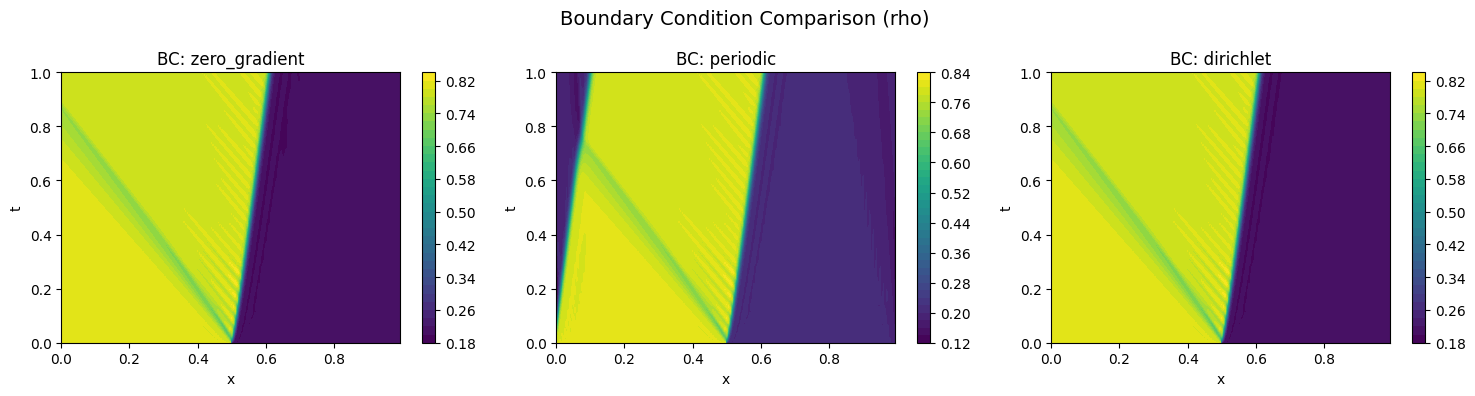

In [5]:
bc_types = ["zero_gradient", "periodic", "dirichlet"]
rho0_bc, v0_bc = riemann(x, rho_left=0.8, rho_right=0.2, v0=0.1)

fig, axes = plt.subplots(1, len(bc_types), figsize=(5 * len(bc_types), 4))
for ax, bc in zip(axes, bc_types):
    kwargs = dict(dx=DX, dt=DT, nt=NT, gamma=GAMMA, bc_type=bc)
    if bc == "dirichlet":
        kwargs["bc_left"] = (0.8, 0.1)
        kwargs["bc_right"] = (0.2, 0.1)
    sol_bc = generate_one(rho0_bc, v0_bc, **kwargs)
    c = ax.contourf(
        sol_bc["x"].numpy(),
        sol_bc["t"].numpy(),
        sol_bc["rho"].numpy(),
        levels=40,
        cmap="viridis",
    )
    fig.colorbar(c, ax=ax)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(f"BC: {bc}")
fig.suptitle("Boundary Condition Comparison (rho)", fontsize=14)
fig.tight_layout()
plt.show()

## 5. Flux & Reconstruction Options

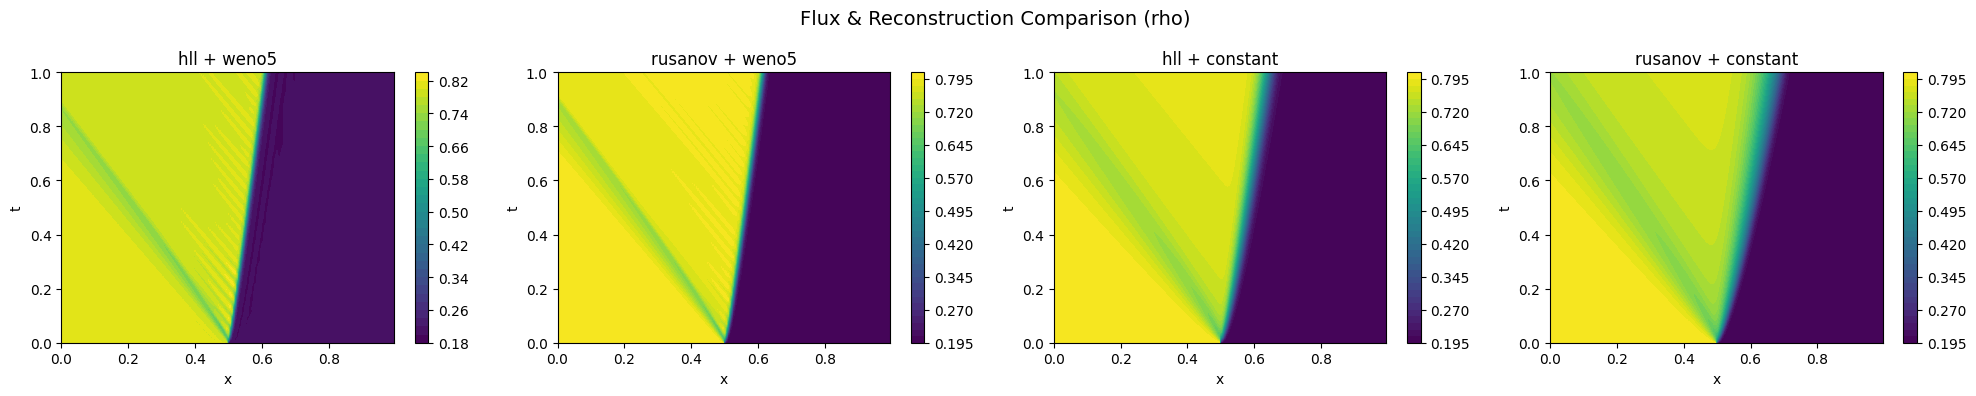

In [6]:
configs = [
    ("hll", "weno5"),
    ("rusanov", "weno5"),
    ("hll", "constant"),
    ("rusanov", "constant"),
]

rho0_f, v0_f = riemann(x, rho_left=0.8, rho_right=0.2, v0=0.1)

fig, axes = plt.subplots(1, len(configs), figsize=(5 * len(configs), 4))
for ax, (flux, recon) in zip(axes, configs):
    sol_cfg = generate_one(
        rho0_f, v0_f, dx=DX, dt=DT, nt=NT, gamma=GAMMA,
        flux_type=flux, reconstruction=recon,
    )
    c = ax.contourf(
        sol_cfg["x"].numpy(),
        sol_cfg["t"].numpy(),
        sol_cfg["rho"].numpy(),
        levels=40,
        cmap="viridis",
    )
    fig.colorbar(c, ax=ax)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(f"{flux} + {recon}")
fig.suptitle("Flux & Reconstruction Comparison (rho)", fontsize=14)
fig.tight_layout()
plt.show()

## 6. Batch Generation (`generate_n`)

ARZ samples: 100%|██████████| 5/5 [00:17<00:00,  3.58s/it]


rho shape: torch.Size([5, 2001, 200])
v   shape: torch.Size([5, 2001, 200])
w   shape: torch.Size([5, 2001, 200])
x   shape: torch.Size([200])
t   shape: torch.Size([2001])


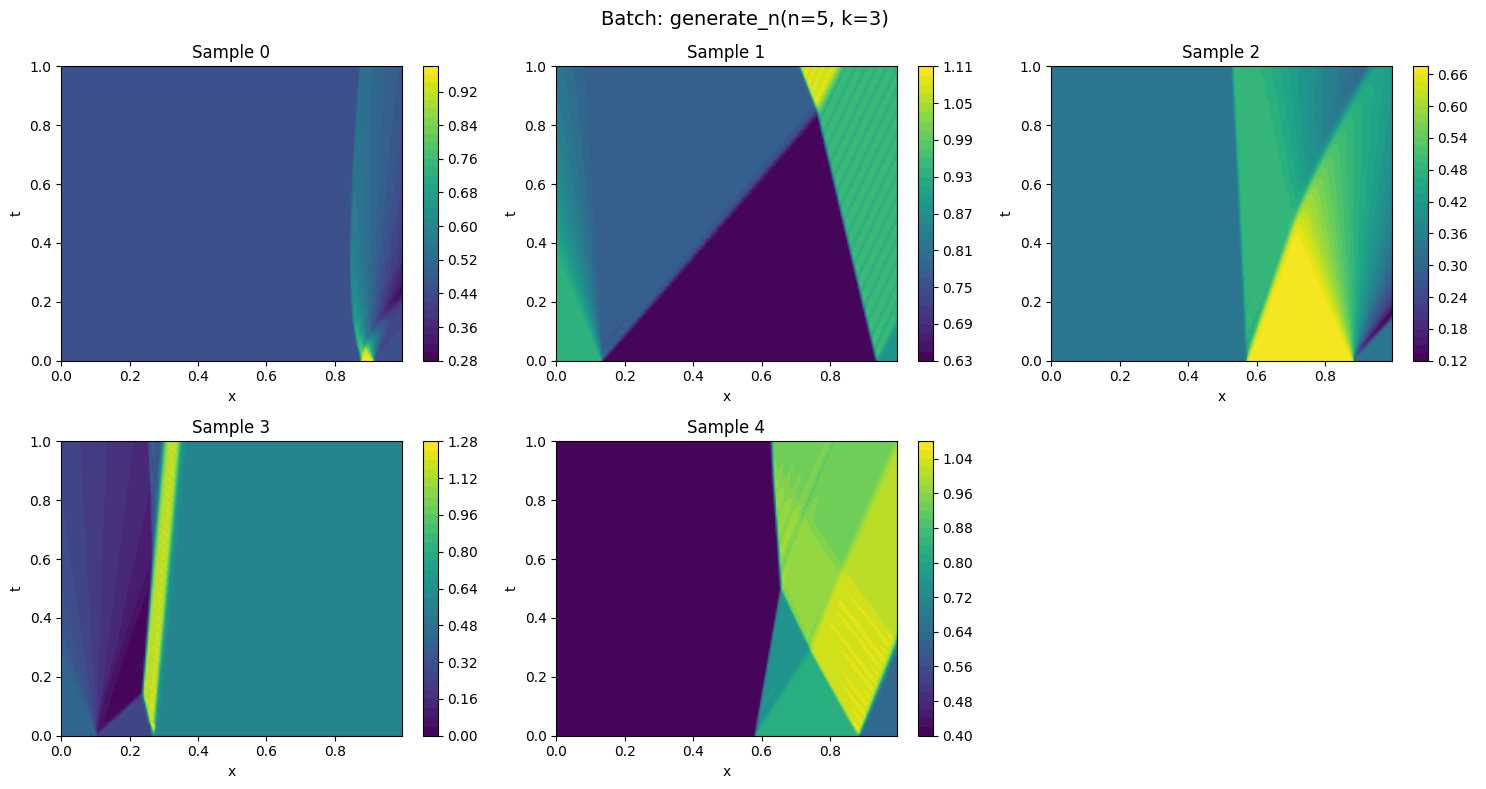

In [7]:
batch = generate_n(
    n=5, k=3, nx=NX, dx=DX, dt=DT, nt=NT, gamma=GAMMA, seed=42,
)

print(f"rho shape: {batch['rho'].shape}")
print(f"v   shape: {batch['v'].shape}")
print(f"w   shape: {batch['w'].shape}")
print(f"x   shape: {batch['x'].shape}")
print(f"t   shape: {batch['t'].shape}")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    if i >= batch["rho"].shape[0]:
        ax.axis("off")
        continue
    c = ax.contourf(
        batch["x"].numpy(),
        batch["t"].numpy(),
        batch["rho"][i].numpy(),
        levels=40,
        cmap="viridis",
    )
    fig.colorbar(c, ax=ax)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(f"Sample {i}")
fig.suptitle("Batch: generate_n(n=5, k=3)", fontsize=14)
fig.tight_layout()
plt.show()

## 7. Physics Helpers

In [8]:
rho_test = torch.tensor([0.0, 0.25, 0.5, 0.75, 1.0])
v_test = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1])
gamma = 1.0

p = pressure(rho_test, gamma)
dp = dp_drho(rho_test, gamma)
lam1, lam2 = eigenvalues(rho_test, v_test, gamma)

print("rho      :", rho_test.tolist())
print("p(rho)   :", p.tolist())
print("p'(rho)  :", dp.tolist())
print("lam1 (v) :", lam1.tolist())
print("lam2     :", lam2.tolist())

# Verify: p(rho) = rho^gamma
assert torch.allclose(p, rho_test**gamma), "pressure mismatch"

# Verify: lam1 = v, lam2 = v - rho * p'(rho)
assert torch.allclose(lam1, v_test), "lam1 mismatch"
assert torch.allclose(lam2, v_test - rho_test * dp), "lam2 mismatch"

print("\nAll assertions passed.")

rho      : [0.0, 0.25, 0.5, 0.75, 1.0]
p(rho)   : [0.0, 0.25, 0.5, 0.75, 1.0]
p'(rho)  : [1.0, 1.0, 1.0, 1.0, 1.0]
lam1 (v) : [0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612]
lam2     : [0.10000000149011612, -0.15000000596046448, -0.4000000059604645, -0.6499999761581421, -0.8999999761581421]

All assertions passed.
